In [ ]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+${CUDA}.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+${CUDA}.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.10.0+${CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.10.0+${CUDA}.html
!pip install torch-geometric
!pip install torch-geometric-temporal

Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+.html
  Created wheel for torch-scatter: filename=torch_scatter-2.0.9-cp37-cp37m-linux_x86_64.whl size=3870620 sha256=f46104ffc4917e65daf0e3d57e59138e1132945caf9ad6650e9578b3117623ed
  Stored in directory: /root/.cache/pip/wheels/dd/57/a3/42ea193b77378ce634eb9454c9bc1e3163f3b482a35cdee4d1
Successfully built torch-scatter
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+.html
     |████████████████████████████████| 48 kB 3.9 MB/s 
  Created wheel for torch-sparse: filename=torch_sparse-0.6.13-cp37-cp37m-linux_x86_64.whl size=1654975 sha256=28f2fba9006a6552a29ed818da4dbd8271d2482cc87e2004b022287b8f40f1f4
  Stored in directory: /root/.cache/pip/wheels/e0/01/be/6b2966e0ff20bb023ae35e5d17903e6e5b4df46dd5892f6be6
Successfully built torch-sparse
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+.html
     |████████████████████████████████| 43 kB 1.9 MB/s 
  Created wheel for torch-cluster: filename

In [ ]:
from datetime import datetime
import geopy.distance
import glob
import numpy as np
import os
import pandas as pd
import scipy.sparse as sp
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric_temporal.nn import STConv
from tqdm import tqdm

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
class FullyConnLayer(nn.Module):
    def __init__(self, c):
        super(FullyConnLayer, self).__init__()
        self.conv = nn.Conv2d(c, 1, 1)

    def forward(self, x):
        return self.conv(x)

class OutputLayer(nn.Module):
    def __init__(self, c, T, n):
        super(OutputLayer, self).__init__()
        self.tconv1 = nn.Conv2d(c, c, (T, 1), 1, dilation = 1, padding = (0,0))
        self.ln = nn.LayerNorm([n, c])
        self.tconv2 = nn.Conv2d(c, c, (1, 1), 1, dilation = 1, padding = (0,0))
        self.fc = FullyConnLayer(c)

    def forward(self, x):
        x_t1 = self.tconv1(x)
        x_ln = self.ln(x_t1.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        x_t2 = self.tconv2(x_ln)

        return self.fc(x_t2)

class TrafficModel(torch.nn.Module):
    def __init__(self, device, num_nodes, channel_size_list, num_layers, 
                 kernel_size, K, window_size, \
                 normalization = 'sym', bias = True):

        super(TrafficModel, self).__init__()
        self.layers = nn.ModuleList([])
        for l in range(num_layers):
            input_size, hidden_size, output_size = \
            channel_size_list[l][0], channel_size_list[l][1], \
            channel_size_list[l][2]
            self.layers.append(STConv(num_nodes, input_size, hidden_size, \
                                      output_size, kernel_size, K, \
                                      normalization, bias))
        self.layers.append(OutputLayer(channel_size_list[-1][-1], \
                                       window_size - 2 * num_layers * (kernel_size - 1), \
                                       num_nodes))
        for layer in self.layers:
            layer = layer.to(device)

    def forward(self, x, edge_index, edge_weight):
        for layer in self.layers[:-1]:
          x = layer(x, edge_index, edge_weight)
        out_layer = self.layers[-1]
        x = x.permute(0, 3, 1, 2)
        x = out_layer(x)
        return x

In [8]:
channels = np.array([[1, 4, 8], [8, 4, 8]])
                                                
kernel_size = 3
K = 3

learning_rate = 0.01
batch_size = 10
num_epochs = 20
num_layers = 1
n_his = 20
          
n_pred = 5
          
train_prop = 0.7
val_prop = 0.2
test_prop = 0.1

model_save_path = os.path.join(
    'drive', 'MyDrive', 'best_model.pt')

In [9]:
def data_transform(data, n_his, n_pred, device):

    num_nodes = data.shape[1]
    num_obs = len(data) - n_his - n_pred
    x = np.zeros([num_obs, n_his, num_nodes, 1])
    y = np.zeros([num_obs, num_nodes])
    
    obs_idx = 0
    for i in range(num_obs):
        head = i
        tail = i + n_his
        x[obs_idx, :, :, :] = data[head: tail].reshape(n_his, num_nodes, 1)
        y[obs_idx] = data[tail + n_pred - 1]
        obs_idx += 1

    return torch.Tensor(x).to(device), torch.Tensor(y).to(device)

In [10]:
weighted_adj_matrix_path = os.path.join('/content/drive/MyDrive/GBDS_Data/processed_data/distances.csv')
W = pd.read_csv(weighted_adj_matrix_path).drop('station_id', axis=1)

feature_vectors_path = os.path.join('/content/drive/MyDrive/GBDS_Data/processed_data/combined.csv')
V = pd.read_csv(feature_vectors_path).drop('time', axis=1)

In [11]:
for pos, col in enumerate(W.columns):
  if col != V.columns[pos]:
    print(col, V.columns[pos])

In [12]:
device = torch.device("cuda") if torch.cuda.is_available() \
else torch.device("cpu")

In [13]:
num_samples, num_nodes = V.shape

len_train = round(num_samples * train_prop)
len_val = round(num_samples * val_prop)
train = V[ : len_train]
val = V[len_train : len_train + len_val]
test = V[len_train + len_val : len_train + len_val + round(num_samples * test_prop)]

scaler = StandardScaler()
train = np.nan_to_num(scaler.fit_transform(train))
val = np.nan_to_num(scaler.transform(val))
test = np.nan_to_num(scaler.transform(test))

x_train, y_train = data_transform(train, n_his, n_pred, device)
x_val, y_val = data_transform(val, n_his, n_pred, device)
x_test, y_test = data_transform(test, n_his, n_pred, device)

train_data = torch.utils.data.TensorDataset(x_train, y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_data = torch.utils.data.TensorDataset(x_val, y_val)
val_iter = torch.utils.data.DataLoader(val_data, batch_size)
test_data = torch.utils.data.TensorDataset(x_test, y_test)
test_iter = torch.utils.data.DataLoader(test_data, batch_size)

G = sp.coo_matrix(W)
edge_index = torch.tensor(np.array([G.row, G.col]), dtype=torch.int64).to(device)
edge_weight = torch.tensor(G.data).float().to(device)

In [14]:
model = TrafficModel(device, num_nodes, channels, num_layers, kernel_size, K, \
                     n_his, normalization = 'sym', bias = True).to(device)

loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 

In [15]:
def evaluate_model(model, loss, data_iter, edge_index, edge_weight, device):
  model.eval()
  l_sum, n = 0.0, 0
  with torch.no_grad():
      for x, y in data_iter:
          y_pred = model(x.to(device), edge_index, edge_weight).view(len(x), -1)
          l = loss(y_pred, y)
          l_sum += l.item() * y.shape[0]
          n += y.shape[0]
      return l_sum / n

def evaluate_metric(model, data_iter, scaler, edge_index, edge_weight, device):
    model.eval()
    epsilon = 1e-6
    with torch.no_grad():
        mae, mape, mse = [], [], []
        for x, y in data_iter:
            y = scaler.inverse_transform(y.cpu().numpy()).reshape(-1)
            y_pred = scaler.inverse_transform(model(x.to(device), \
                                                    edge_index, \
                                                    edge_weight).view(len(x), -1).cpu().numpy()).reshape(-1)
            d = np.abs(y - y_pred)
            mae += d.tolist()
            mape += (d / (y+epsilon)).tolist()
            mse += (d ** 2).tolist()
        MAE = np.array(mae).mean()
        MAPE = np.array(mape).mean()
        RMSE = np.sqrt(np.array(mse).mean())
        return MAE, MAPE, RMSE

In [16]:
min_val_loss = np.inf
for epoch in tqdm(range(1, num_epochs + 1), desc = 'Epoch', position = 0):
  l_sum, n = 0.0, 0

  model.train()

  for x, y in tqdm(train_iter, desc = 'Batch', position = 0):

    y_pred = model(x.to(device), edge_index, edge_weight).view(len(x), -1)
    l = loss(y_pred, y)

    optimizer.zero_grad()
    l.backward()
    optimizer.step()

    l_sum += l.item() * y.shape[0]
    n += y.shape[0]

  val_loss = evaluate_model(model, loss, val_iter, edge_index, edge_weight, device)
  if val_loss < min_val_loss:
      min_val_loss = val_loss
      torch.save(model.state_dict(), model_save_path)
  print("epoch", epoch, ", train loss:", l_sum / n, ", validation loss:", val_loss)

Epoch:   5%|▌         | 1/20 [02:24<45:43, 144.39s/it]

epoch 1 , train loss: 0.8476071336504645 , validation loss: 1.5885800464298336


Epoch:  10%|█         | 2/20 [04:48<43:12, 144.04s/it]

epoch 2 , train loss: 0.8018855781788016 , validation loss: 1.577380921904125


Epoch:  15%|█▌        | 3/20 [07:12<40:47, 143.97s/it]

epoch 3 , train loss: 0.7890582457563763 , validation loss: 1.5609603408624917


Epoch:  20%|██        | 4/20 [09:35<38:22, 143.90s/it]

epoch 4 , train loss: 0.784241898135033 , validation loss: 1.5443311930835928


Epoch:  25%|██▌       | 5/20 [11:59<35:58, 143.88s/it]

epoch 5 , train loss: 0.7765300209015334 , validation loss: 1.5747990270531222


Epoch:  30%|███       | 6/20 [14:23<33:34, 143.86s/it]

epoch 6 , train loss: 0.7719165323224461 , validation loss: 1.571816433065291


Epoch:  35%|███▌      | 7/20 [16:47<31:10, 143.86s/it]

epoch 7 , train loss: 0.7666796353680677 , validation loss: 1.5388281102869448


Epoch:  40%|████      | 8/20 [19:11<28:46, 143.85s/it]

epoch 8 , train loss: 0.7701734652172392 , validation loss: 1.547397415787548


Epoch:  45%|████▌     | 9/20 [21:35<26:22, 143.86s/it]

epoch 9 , train loss: 0.758053418699868 , validation loss: 1.5480058799451748


Epoch:  50%|█████     | 10/20 [24:01<24:05, 144.52s/it]

epoch 10 , train loss: 0.7557123823059175 , validation loss: 1.5331156401126558


Epoch:  55%|█████▌    | 11/20 [26:27<21:44, 144.97s/it]

epoch 11 , train loss: 0.7478388065239178 , validation loss: 1.5454102316056821


Epoch:  60%|██████    | 12/20 [28:51<19:18, 144.80s/it]

epoch 12 , train loss: 0.7473447008753842 , validation loss: 1.5653159261429719


Epoch:  65%|██████▌   | 13/20 [31:15<16:51, 144.52s/it]

epoch 13 , train loss: 0.7415103189578983 , validation loss: 1.5391684109947075


Epoch:  70%|███████   | 14/20 [33:39<14:25, 144.33s/it]

epoch 14 , train loss: 0.7415629886659213 , validation loss: 1.5411196797519582


Epoch:  75%|███████▌  | 15/20 [36:03<12:00, 144.19s/it]

epoch 15 , train loss: 0.7358926544354382 , validation loss: 1.5411143243992738


Epoch:  80%|████████  | 16/20 [38:26<09:36, 144.08s/it]

epoch 16 , train loss: 0.7351095141011119 , validation loss: 1.538014349602021


Epoch:  85%|████████▌ | 17/20 [40:50<07:12, 144.02s/it]

epoch 17 , train loss: 0.7309591537332001 , validation loss: 1.5580147682713918


Epoch:  90%|█████████ | 18/20 [43:14<04:47, 143.95s/it]

epoch 18 , train loss: 0.7292169927338011 , validation loss: 1.5647044559168726


Epoch:  95%|█████████▌| 19/20 [45:38<02:23, 143.92s/it]

epoch 19 , train loss: 0.7270173810627065 , validation loss: 1.5382256361694844


Epoch: 100%|██████████| 20/20 [48:02<00:00, 144.12s/it]

epoch 20 , train loss: 0.725472351905652 , validation loss: 1.5460941869723026


In [17]:
best_model = TrafficModel(device, num_nodes, channels, num_layers, kernel_size, K, \
                     n_his, normalization = 'sym', bias = True).to(device)
best_model.load_state_dict(torch.load(model_save_path))

l = evaluate_model(best_model, loss, test_iter, edge_index, edge_weight, device)
MAE, MAPE, RMSE = evaluate_metric(best_model, test_iter, scaler, edge_index, edge_weight, device)
print("test loss:", l, "\nMAE:", MAE, ", MAPE:", MAPE, ", RMSE:", RMSE)

test loss: 1.770578714979797 
MAE: 1.8402484355001114 , MAPE: 434394.4800950068 , RMSE: 3.0884448658697674


In [18]:
predict_model = best_model

pred_save_path = os.path.join(
    'drive', 'MyDrive',  'predictions_testing.csv')

In [19]:
def get_predictions(model, pred_iter, scaler, edge_index, edge_weight, num_nodes, device):
    model.eval()
    with torch.no_grad():
      for x, y in pred_iter:
        y = scaler.inverse_transform(y.cpu().numpy()).reshape(-1)
        y_pred = scaler.inverse_transform(model(x.to(device), \
                                                edge_index, \
                                                edge_weight).view(len(x), -1).cpu().numpy()).reshape(-1)
        y_pred = y_pred.reshape(-1, num_nodes)
      
      return y, y_pred

In [56]:
pred_len = 144

pred_set = V[(-pred_len - n_his - n_pred):]
pred_set = np.nan_to_num(scaler.transform(pred_set))
x_pred, y_pred = data_transform(pred_set, n_his, n_pred, device)
pred_data = torch.utils.data.TensorDataset(x_pred, y_pred)
pred_iter = torch.utils.data.DataLoader(pred_data, pred_len + n_his + n_pred + 1)

predictions = get_predictions(predict_model, pred_iter, scaler, edge_index, edge_weight, 1475, device)
np.savetxt(pred_save_path, predictions[1], delimiter=',')

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)

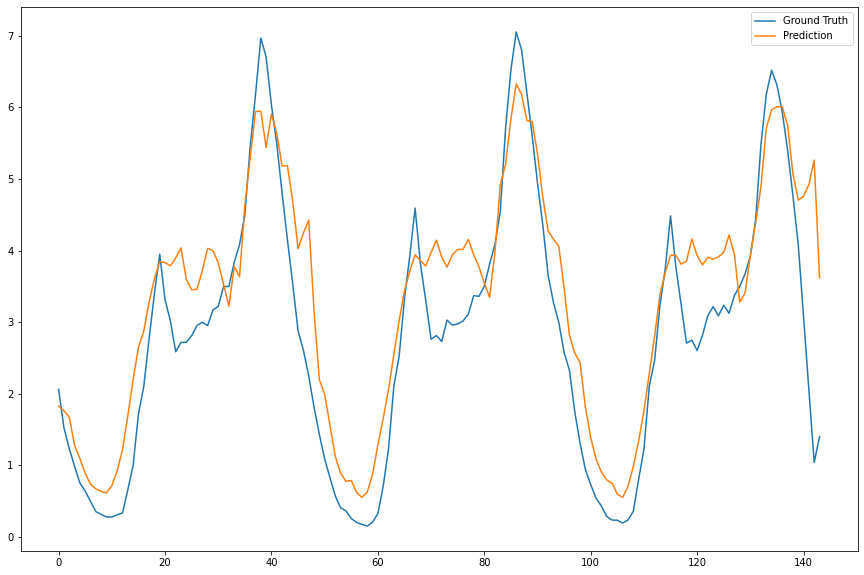

In [92]:
test_preds = pd.read_csv(pred_save_path, header=None)
test_truth = V[(-pred_len-2):-2]
summed_test_truth  = test_truth.mean(axis=1)
summed_test_preds = test_preds.mean(axis=1)
sns.lineplot(y=summed_test_truth, x=range(len(summed_test_preds)))
sns.lineplot(y=summed_test_preds, x=range(len(summed_test_preds)))
plt.legend(labels=['Ground Truth', 'Prediction']);

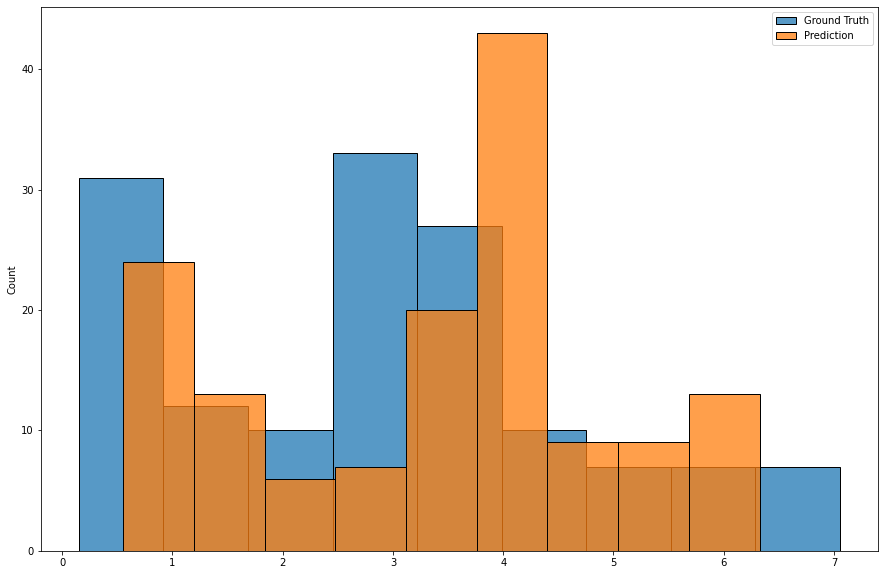

In [94]:
test_preds = pd.read_csv(pred_save_path, header=None)
test_truth = V[(-pred_len-2):-2]
summed_test_truth  = test_truth.mean(axis=1)
summed_test_preds = test_preds.mean(axis=1)
sns.histplot(summed_test_truth)
sns.histplot(summed_test_preds, color=sns.color_palette()[1])
plt.legend(labels=['Ground Truth', 'Prediction']);

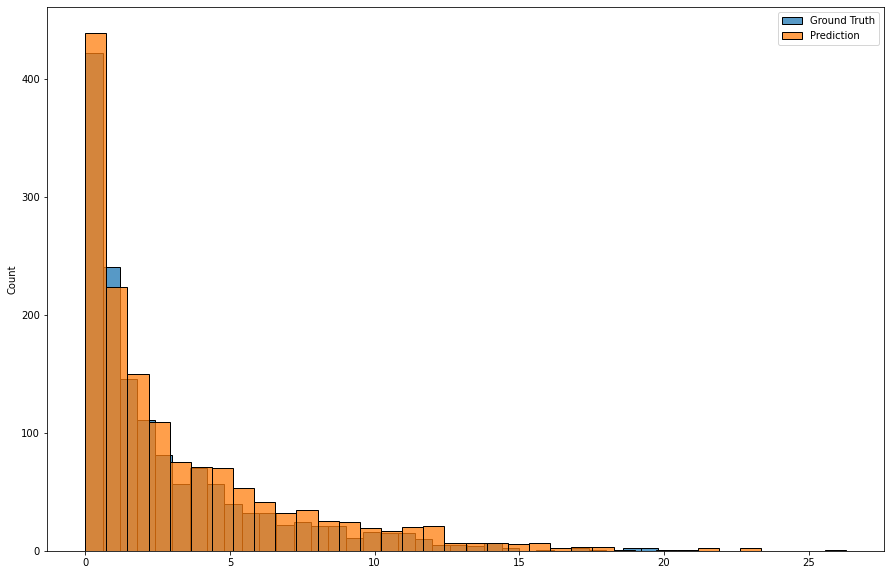

In [95]:
test_preds = pd.read_csv(pred_save_path, header=None)
test_truth = V[(-pred_len-2):-2]
summed_test_truth  = test_truth.mean(axis=0)
summed_test_preds = test_preds.mean(axis=0)
sns.histplot(summed_test_truth)
sns.histplot(summed_test_preds, color=sns.color_palette()[1])
plt.legend(labels=['Ground Truth', 'Prediction']);